In [ ]:
##imports
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
##imports mas interesantes
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
%matplotlib inline

In [ ]:
import shutil

#shutil.rmtree('/folder_name')
#shutil.rmtree('/content/imagenes01', ignore_errors=True)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#@title bing_images_download.py
%%writefile bing_images_download.py
#!/usr/bin/env python
# In[ ]:
#  coding: utf-8

###### Searching and Downloading Google Images to the local disk ######

# Updated by Evan Sellers <sellersew@gmail.com> Feb 2020
# Now uses bing search and only supports url

# Import Libraries
import sys
version = (3, 0)
cur_version = sys.version_info
if cur_version >= version:  # If the Current Version of Python is 3.0 or above
    import urllib.request
    from urllib.request import Request, urlopen
    from urllib.request import URLError, HTTPError
    from urllib.parse import quote
    import http.client
    from http.client import IncompleteRead, BadStatusLine
    http.client._MAXHEADERS = 1000
else:  # If the Current Version of Python is 2.x
    import urllib2
    from urllib2 import Request, urlopen
    from urllib2 import URLError, HTTPError
    from urllib import quote
    import httplib
    from httplib import IncompleteRead, BadStatusLine
    httplib._MAXHEADERS = 1000
import time  # Importing the time library to check the time of code execution
import os
import html
import argparse
import ssl
import datetime
import json
import re
import codecs
import socket

args_list = ["keywords", "keywords_from_file", "prefix_keywords", "suffix_keywords",
             "limit", "format", "color", "color_type", "usage_rights", "size",
             "exact_size", "aspect_ratio", "type", "time", "time_range", "delay", "url", "single_image",
             "output_directory", "image_directory", "no_directory", "proxy", "similar_images", "specific_site",
             "print_urls", "print_size", "print_paths", "metadata", "extract_metadata", "socket_timeout",
             "thumbnail", "thumbnail_only", "language", "prefix", "chromedriver", "related_images", "safe_search", "no_numbering",
             "offset", "no_download","save_source","silent_mode","ignore_urls"]


def user_input():
    config = argparse.ArgumentParser()
    config.add_argument('-cf', '--config_file', help='config file name', default='', type=str, required=False)
    config_file_check = config.parse_known_args()
    object_check = vars(config_file_check[0])

    if object_check['config_file'] != '':
        records = []
        json_file = json.load(open(config_file_check[0].config_file))
        for record in range(0,len(json_file['Records'])):
            arguments = {}
            for i in args_list:
                arguments[i] = None
            for key, value in json_file['Records'][record].items():
                arguments[key] = value
            records.append(arguments)
        records_count = len(records)
    else:
        # Taking command line arguments from users
        parser = argparse.ArgumentParser()
        parser.add_argument('-k', '--keywords', help='delimited list input', type=str, required=False)
        parser.add_argument('-kf', '--keywords_from_file', help='extract list of keywords from a text file', type=str, required=False)
        parser.add_argument('-sk', '--suffix_keywords', help='comma separated additional words added after to main keyword', type=str, required=False)
        parser.add_argument('-pk', '--prefix_keywords', help='comma separated additional words added before main keyword', type=str, required=False)
        parser.add_argument('-l', '--limit', help='delimited list input', type=str, required=False)
        parser.add_argument('-f', '--format', help='download images with specific format', type=str, required=False,
                            choices=['jpg', 'gif', 'png', 'bmp', 'svg', 'webp', 'ico'])
        parser.add_argument('-u', '--url', help='search with google image URL', type=str, required=False)
        parser.add_argument('-x', '--single_image', help='downloading a single image from URL', type=str, required=False)
        parser.add_argument('-o', '--output_directory', help='download images in a specific main directory', type=str, required=False)
        parser.add_argument('-i', '--image_directory', help='download images in a specific sub-directory', type=str, required=False)
        parser.add_argument('-n', '--no_directory', default=False, help='download images in the main directory but no sub-directory', action="store_true")
        parser.add_argument('-d', '--delay', help='delay in seconds to wait between downloading two images', type=int, required=False)
        parser.add_argument('-co', '--color', help='filter on color', type=str, required=False,
                            choices=['red', 'orange', 'yellow', 'green', 'teal', 'blue', 'purple', 'pink', 'white', 'gray', 'black', 'brown'])
        parser.add_argument('-ct', '--color_type', help='filter on color', type=str, required=False,
                            choices=['full-color', 'black-and-white', 'transparent'])
        parser.add_argument('-r', '--usage_rights', help='usage rights', type=str, required=False,
                            choices=['labeled-for-reuse-with-modifications','labeled-for-reuse','labeled-for-noncommercial-reuse-with-modification','labeled-for-nocommercial-reuse'])
        parser.add_argument('-s', '--size', help='image size', type=str, required=False,
                            choices=['large','medium','icon','>400*300','>640*480','>800*600','>1024*768','>2MP','>4MP','>6MP','>8MP','>10MP','>12MP','>15MP','>20MP','>40MP','>70MP'])
        parser.add_argument('-es', '--exact_size', help='exact image resolution "WIDTH,HEIGHT"', type=str, required=False)
        parser.add_argument('-t', '--type', help='image type', type=str, required=False,
                            choices=['face','photo','clipart','line-drawing','animated'])
        parser.add_argument('-w', '--time', help='image age', type=str, required=False,
                            choices=['past-24-hours','past-7-days','past-month','past-year'])
        parser.add_argument('-wr', '--time_range', help='time range for the age of the image. should be in the format {"time_min":"MM/DD/YYYY","time_max":"MM/DD/YYYY"}', type=str, required=False)
        parser.add_argument('-a', '--aspect_ratio', help='comma separated additional words added to keywords', type=str, required=False,
                            choices=['tall', 'square', 'wide', 'panoramic'])
        parser.add_argument('-si', '--similar_images', help='downloads images very similar to the image URL you provide', type=str, required=False)
        parser.add_argument('-ss', '--specific_site', help='downloads images that are indexed from a specific website', type=str, required=False)
        parser.add_argument('-p', '--print_urls', default=False, help="Print the URLs of the images", action="store_true")
        parser.add_argument('-ps', '--print_size', default=False, help="Print the size of the images on disk", action="store_true")
        parser.add_argument('-pp', '--print_paths', default=False, help="Prints the list of absolute paths of the images",action="store_true")
        parser.add_argument('-m', '--metadata', default=False, help="Print the metadata of the image", action="store_true")
        parser.add_argument('-e', '--extract_metadata', default=False, help="Dumps all the logs into a text file", action="store_true")
        parser.add_argument('-st', '--socket_timeout', default=False, help="Connection timeout waiting for the image to download", type=float)
        parser.add_argument('-th', '--thumbnail', default=False, help="Downloads image thumbnail along with the actual image", action="store_true")
        parser.add_argument('-tho', '--thumbnail_only', default=False, help="Downloads only thumbnail without downloading actual images", action="store_true")
        parser.add_argument('-la', '--language', default=False, help="Defines the language filter. The search results are authomatically returned in that language", type=str, required=False,
                            choices=['Arabic','Chinese (Simplified)','Chinese (Traditional)','Czech','Danish','Dutch','English','Estonian','Finnish','French','German','Greek','Hebrew','Hungarian','Icelandic','Italian','Japanese','Korean','Latvian','Lithuanian','Norwegian','Portuguese','Polish','Romanian','Russian','Spanish','Swedish','Turkish'])
        parser.add_argument('-pr', '--prefix', default=False, help="A word that you would want to prefix in front of each image name", type=str, required=False)
        parser.add_argument('-px', '--proxy', help='specify a proxy address and port', type=str, required=False)
        parser.add_argument('-cd', '--chromedriver', help='specify the path to chromedriver executable in your local machine', type=str, required=False)
        parser.add_argument('-ri', '--related_images', default=False, help="Downloads images that are similar to the keyword provided", action="store_true")
        parser.add_argument('-sa', '--safe_search', default=False, help="Turns on the safe search filter while searching for images", action="store_true")
        parser.add_argument('-nn', '--no_numbering', default=False, help="Allows you to exclude the default numbering of images", action="store_true")
        parser.add_argument('-of', '--offset', help="Where to start in the fetched links", type=str, required=False)
        parser.add_argument('-nd', '--no_download', default=False, help="Prints the URLs of the images and/or thumbnails without downloading them", action="store_true")
        parser.add_argument('-iu', '--ignore_urls', default=False, help="delimited list input of image urls/keywords to ignore", type=str)
        parser.add_argument('-sil', '--silent_mode', default=False, help="Remains silent. Does not print notification messages on the terminal", action="store_true")
        parser.add_argument('-is', '--save_source', help="creates a text file containing a list of downloaded images along with source page url", type=str, required=False)

        args = parser.parse_args()
        arguments = vars(args)
        records = []
        records.append(arguments)
    return records


class googleimagesdownload:
    def __init__(self):
        pass

    # Downloading entire Web Document (Raw Page Content)
    def download_page(self,url):
        version = (3, 0)
        cur_version = sys.version_info
        if cur_version >= version:  # If the Current Version of Python is 3.0 or above
            try:
                headers = {}
                headers['User-Agent'] = "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36"
                req = urllib.request.Request(url, headers=headers)
                resp = urllib.request.urlopen(req)
                respData = str(resp.read())
                return respData
            except Exception as e:
                print("Could not open URL. Please check your internet connection and/or ssl settings \n"
                      "If you are using proxy, make sure your proxy settings is configured correctly")
                sys.exit()
        else:  # If the Current Version of Python is 2.x
            try:
                headers = {}
                headers['User-Agent'] = "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"
                req = urllib2.Request(url, headers=headers)
                try:
                    response = urllib2.urlopen(req)
                except URLError:  # Handling SSL certificate failed
                    context = ssl._create_unverified_context()
                    response = urlopen(req, context=context)
                page = response.read()
                return page
            except:
                print("Could not open URL. Please check your internet connection and/or ssl settings \n"
                      "If you are using proxy, make sure your proxy settings is configured correctly")
                sys.exit()
                return "Page Not found"


    # Download Page for more than 100 images
    def download_extended_page(self,url,chromedriver):
        from selenium import webdriver
        from selenium.webdriver.common.keys import Keys
        if sys.version_info[0] < 3:
            reload(sys)
            sys.setdefaultencoding('utf8')
        options = webdriver.ChromeOptions()
        options.add_argument('--no-sandbox')
        options.add_argument("--headless")

        try:
            browser = webdriver.Chrome(chromedriver, chrome_options=options)
        except Exception as e:
            print("Looks like we cannot locate the path the 'chromedriver' (use the '--chromedriver' "
                  "argument to specify the path to the executable.) or google chrome browser is not "
                  "installed on your machine (exception: %s)" % e)
            sys.exit()
        browser.set_window_size(1024, 768)

        # Open the link
        browser.get(url)
        time.sleep(1)
        print("Getting you a lot of images. This may take a few moments...")

        element = browser.find_element_by_tag_name("body")
        # Scroll down
        for i in range(30):
            element.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.3)

        try:
            browser.find_element_by_id("smb").click()
            for i in range(50):
                element.send_keys(Keys.PAGE_DOWN)
                time.sleep(0.3)  # bot id protection
        except:
            for i in range(10):
                element.send_keys(Keys.PAGE_DOWN)
                time.sleep(0.3)  # bot id protection

        print("Reached end of Page.")
        time.sleep(0.5)

        source = browser.page_source #page source
        #close the browser
        browser.close()

        return source


    #Correcting the escape characters for python2
    def replace_with_byte(self,match):
        return chr(int(match.group(0)[1:], 8))

    def repair(self,brokenjson):
        invalid_escape = re.compile(r'\\[0-7]{1,3}')  # up to 3 digits for byte values up to FF
        return invalid_escape.sub(self.replace_with_byte, brokenjson)


    # Finding 'Next Image' from the given raw page
    def get_next_tab(self,s):
        start_line = s.find('class="dtviD"')
        if start_line == -1:  # If no links are found then give an error!
            end_quote = 0
            link = "no_tabs"
            return link,'',end_quote
        else:
            start_line = s.find('class="dtviD"')
            start_content = s.find('href="', start_line + 1)
            end_content = s.find('">', start_content + 1)
            url_item = "https://www.google.com" + str(s[start_content + 6:end_content])
            url_item = url_item.replace('&amp;', '&')

            start_line_2 = s.find('class="dtviD"')
            s = s.replace('&amp;', '&')
            start_content_2 = s.find(':', start_line_2 + 1)
            end_content_2 = s.find('&usg=', start_content_2 + 1)
            url_item_name = str(s[start_content_2 + 1:end_content_2])

            chars = url_item_name.find(',g_1:')
            chars_end = url_item_name.find(":", chars + 6)
            if chars_end == -1:
                updated_item_name = (url_item_name[chars + 5:]).replace("+", " ")
            else:
                updated_item_name = (url_item_name[chars+5:chars_end]).replace("+", " ")

            return url_item, updated_item_name, end_content


    # Getting all links with the help of '_images_get_next_image'
    def get_all_tabs(self,page):
        tabs = {}
        while True:
            item,item_name,end_content = self.get_next_tab(page)
            if item == "no_tabs":
                break
            else:
                if len(item_name) > 100 or item_name == "background-color":
                    break
                else:
                    tabs[item_name] = item  # Append all the links in the list named 'Links'
                    time.sleep(0.1)  # Timer could be used to slow down the request for image downloads
                    page = page[end_content:]
        return tabs



    #Format the object in readable format
    def format_object(self,object):
        formatted_object = {}
        formatted_object['image_format'] = object['murl'].split(".")[-1];
        formatted_object['image_height'] = False;
        formatted_object['image_width'] = False;
        formatted_object['image_link'] = object['murl'].replace(" ", "+");
        formatted_object['image_description'] = object['desc']
        formatted_object['image_host'] = object['purl']
        formatted_object['image_source'] = object['purl']
        formatted_object['image_thumbnail_url'] = object['murl']
        return formatted_object


    #function to download single image
    def single_image(self,image_url):
        main_directory = "downloads"
        extensions = (".jpg", ".gif", ".png", ".bmp", ".svg", ".webp", ".ico")
        url = image_url
        try:
            os.makedirs(main_directory)
        except OSError as e:
            if e.errno != 17:
                raise
            pass
        req = Request(url, headers={
            "User-Agent": "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"})

        response = urlopen(req, None, 10)
        data = response.read()
        response.close()

        image_name = str(url[(url.rfind('/')) + 1:])
        if '?' in image_name:
            image_name = image_name[:image_name.find('?')]
        # if ".jpg" in image_name or ".gif" in image_name or ".png" in image_name or ".bmp" in image_name or ".svg" in image_name or ".webp" in image_name or ".ico" in image_name:
        if any(map(lambda extension: extension in image_name, extensions)):
            file_name = main_directory + "/" + image_name
        else:
            file_name = main_directory + "/" + image_name + ".jpg"
            image_name = image_name + ".jpg"

        try:
            output_file = open(file_name, 'wb')
            output_file.write(data)
            output_file.close()
        except IOError as e:
            raise e
        except OSError as e:
            raise e
        print("completed ====> " + image_name.encode('raw_unicode_escape').decode('utf-8'))
        return

    def similar_images(self,similar_images):
        version = (3, 0)
        cur_version = sys.version_info
        if cur_version >= version:  # If the Current Version of Python is 3.0 or above
            try:
                searchUrl = 'https://www.google.com/searchbyimage?site=search&sa=X&image_url=' + similar_images
                headers = {}
                headers['User-Agent'] = "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36"

                req1 = urllib.request.Request(searchUrl, headers=headers)
                resp1 = urllib.request.urlopen(req1)
                content = str(resp1.read())
                l1 = content.find('AMhZZ')
                l2 = content.find('&', l1)
                urll = content[l1:l2]

                newurl = "https://www.google.com/search?tbs=sbi:" + urll + "&site=search&sa=X"
                req2 = urllib.request.Request(newurl, headers=headers)
                resp2 = urllib.request.urlopen(req2)
                l3 = content.find('/search?sa=X&amp;q=')
                l4 = content.find(';', l3 + 19)
                urll2 = content[l3 + 19:l4]
                return urll2
            except:
                return "Cloud not connect to Google Images endpoint"
        else:  # If the Current Version of Python is 2.x
            try:
                searchUrl = 'https://www.google.com/searchbyimage?site=search&sa=X&image_url=' + similar_images
                headers = {}
                headers['User-Agent'] = "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"

                req1 = urllib2.Request(searchUrl, headers=headers)
                resp1 = urllib2.urlopen(req1)
                content = str(resp1.read())
                l1 = content.find('AMhZZ')
                l2 = content.find('&', l1)
                urll = content[l1:l2]

                newurl = "https://www.google.com/search?tbs=sbi:" + urll + "&site=search&sa=X"
                req2 = urllib2.Request(newurl, headers=headers)
                resp2 = urllib2.urlopen(req2)
                l3 = content.find('/search?sa=X&amp;q=')
                l4 = content.find(';', l3 + 19)
                urll2 = content[l3 + 19:l4]
                return(urll2)
            except:
                return "Cloud not connect to Google Images endpoint"

    #Building URL parameters
    def build_url_parameters(self,arguments):
        if arguments['language']:
            lang = "&lr="
            lang_param = {"Arabic":"lang_ar","Chinese (Simplified)":"lang_zh-CN","Chinese (Traditional)":"lang_zh-TW","Czech":"lang_cs","Danish":"lang_da","Dutch":"lang_nl","English":"lang_en","Estonian":"lang_et","Finnish":"lang_fi","French":"lang_fr","German":"lang_de","Greek":"lang_el","Hebrew":"lang_iw ","Hungarian":"lang_hu","Icelandic":"lang_is","Italian":"lang_it","Japanese":"lang_ja","Korean":"lang_ko","Latvian":"lang_lv","Lithuanian":"lang_lt","Norwegian":"lang_no","Portuguese":"lang_pt","Polish":"lang_pl","Romanian":"lang_ro","Russian":"lang_ru","Spanish":"lang_es","Swedish":"lang_sv","Turkish":"lang_tr"}
            lang_url = lang+lang_param[arguments['language']]
        else:
            lang_url = ''

        if arguments['time_range']:
            json_acceptable_string = arguments['time_range'].replace("'", "\"")
            d = json.loads(json_acceptable_string)
            time_range = ',cdr:1,cd_min:' + d['time_min'] + ',cd_max:' + d['time_max']
        else:
            time_range = ''

        if arguments['exact_size']:
            size_array = [x.strip() for x in arguments['exact_size'].split(',')]
            exact_size = ",isz:ex,iszw:" + str(size_array[0]) + ",iszh:" + str(size_array[1])
        else:
            exact_size = ''

        built_url = "&tbs="
        counter = 0
        params = {'color':[arguments['color'],{'red':'ic:specific,isc:red', 'orange':'ic:specific,isc:orange', 'yellow':'ic:specific,isc:yellow', 'green':'ic:specific,isc:green', 'teal':'ic:specific,isc:teel', 'blue':'ic:specific,isc:blue', 'purple':'ic:specific,isc:purple', 'pink':'ic:specific,isc:pink', 'white':'ic:specific,isc:white', 'gray':'ic:specific,isc:gray', 'black':'ic:specific,isc:black', 'brown':'ic:specific,isc:brown'}],
                  'color_type':[arguments['color_type'],{'full-color':'ic:color', 'black-and-white':'ic:gray','transparent':'ic:trans'}],
                  'usage_rights':[arguments['usage_rights'],{'labeled-for-reuse-with-modifications':'sur:fmc','labeled-for-reuse':'sur:fc','labeled-for-noncommercial-reuse-with-modification':'sur:fm','labeled-for-nocommercial-reuse':'sur:f'}],
                  'size':[arguments['size'],{'large':'isz:l','medium':'isz:m','icon':'isz:i','>400*300':'isz:lt,islt:qsvga','>640*480':'isz:lt,islt:vga','>800*600':'isz:lt,islt:svga','>1024*768':'visz:lt,islt:xga','>2MP':'isz:lt,islt:2mp','>4MP':'isz:lt,islt:4mp','>6MP':'isz:lt,islt:6mp','>8MP':'isz:lt,islt:8mp','>10MP':'isz:lt,islt:10mp','>12MP':'isz:lt,islt:12mp','>15MP':'isz:lt,islt:15mp','>20MP':'isz:lt,islt:20mp','>40MP':'isz:lt,islt:40mp','>70MP':'isz:lt,islt:70mp'}],
                  'type':[arguments['type'],{'face':'itp:face','photo':'itp:photo','clipart':'itp:clipart','line-drawing':'itp:lineart','animated':'itp:animated'}],
                  'time':[arguments['time'],{'past-24-hours':'qdr:d','past-7-days':'qdr:w','past-month':'qdr:m','past-year':'qdr:y'}],
                  'aspect_ratio':[arguments['aspect_ratio'],{'tall':'iar:t','square':'iar:s','wide':'iar:w','panoramic':'iar:xw'}],
                  'format':[arguments['format'],{'jpg':'ift:jpg','gif':'ift:gif','png':'ift:png','bmp':'ift:bmp','svg':'ift:svg','webp':'webp','ico':'ift:ico','raw':'ift:craw'}]}
        for key, value in params.items():
            if value[0] is not None:
                ext_param = value[1][value[0]]
                # counter will tell if it is first param added or not
                if counter == 0:
                    # add it to the built url
                    built_url = built_url + ext_param
                    counter += 1
                else:
                    built_url = built_url + ',' + ext_param
                    counter += 1
        built_url = lang_url+built_url+exact_size+time_range
        return built_url


    #building main search URL
    def build_search_url(self,search_term,params,url,similar_images,specific_site,safe_search):
        #check safe_search
        safe_search_string = "&safe=active"
        # check the args and choose the URL
        if url:
            url = url
        elif similar_images:
            print(similar_images)
            keywordem = self.similar_images(similar_images)
            url = 'https://www.google.com/search?q=' + keywordem + '&espv=2&biw=1366&bih=667&site=webhp&source=lnms&tbm=isch&sa=X&ei=XosDVaCXD8TasATItgE&ved=0CAcQ_AUoAg'
        elif specific_site:
            url = 'https://www.google.com/search?q=' + quote(
                search_term.encode('utf-8')) + '&as_sitesearch=' + specific_site + '&espv=2&biw=1366&bih=667&site=webhp&source=lnms&tbm=isch' + params + '&sa=X&ei=XosDVaCXD8TasATItgE&ved=0CAcQ_AUoAg'
        else:
            url = 'https://www.google.com/search?q=' + quote(
                search_term.encode('utf-8')) + '&espv=2&biw=1366&bih=667&site=webhp&source=lnms&tbm=isch' + params + '&sa=X&ei=XosDVaCXD8TasATItgE&ved=0CAcQ_AUoAg'

        #safe search check
        if safe_search:
            url = url + safe_search_string

        return url


    #measures the file size
    def file_size(self,file_path):
        if os.path.isfile(file_path):
            file_info = os.stat(file_path)
            size = file_info.st_size
            for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
                if size < 1024.0:
                    return "%3.1f %s" % (size, x)
                size /= 1024.0
            return size

    #keywords from file
    def keywords_from_file(self,file_name):
        search_keyword = []
        with codecs.open(file_name, 'r', encoding='utf-8-sig') as f:
            if '.csv' in file_name:
                for line in f:
                    if line in ['\n', '\r\n']:
                        pass
                    else:
                        search_keyword.append(line.replace('\n', '').replace('\r', ''))
            elif '.txt' in file_name:
                for line in f:
                    if line in ['\n', '\r\n']:
                        pass
                    else:
                        search_keyword.append(line.replace('\n', '').replace('\r', ''))
            else:
                print("Invalid file type: Valid file types are either .txt or .csv \n"
                      "exiting...")
                sys.exit()
        return search_keyword

    # make directories
    def create_directories(self,main_directory, dir_name,thumbnail,thumbnail_only):
        dir_name_thumbnail = dir_name + " - thumbnail"
        # make a search keyword  directory
        try:
            if not os.path.exists(main_directory):
                os.makedirs(main_directory)
                time.sleep(0.2)
                path = (dir_name)
                sub_directory = os.path.join(main_directory, path)
                if not os.path.exists(sub_directory):
                    os.makedirs(sub_directory)
                if thumbnail or thumbnail_only:
                    sub_directory_thumbnail = os.path.join(main_directory, dir_name_thumbnail)
                    if not os.path.exists(sub_directory_thumbnail):
                        os.makedirs(sub_directory_thumbnail)
            else:
                path = (dir_name)
                sub_directory = os.path.join(main_directory, path)
                if not os.path.exists(sub_directory):
                    os.makedirs(sub_directory)
                if thumbnail or thumbnail_only:
                    sub_directory_thumbnail = os.path.join(main_directory, dir_name_thumbnail)
                    if not os.path.exists(sub_directory_thumbnail):
                        os.makedirs(sub_directory_thumbnail)
        except OSError as e:
            if e.errno != 17:
                raise
            pass
        return


    # Download Image thumbnails
    def download_image_thumbnail(self,image_url,main_directory,dir_name,return_image_name,print_urls,socket_timeout,print_size,no_download,save_source,img_src,ignore_urls):
        if print_urls or no_download:
            print("Image URL: " + image_url)
        if no_download:
            return "success","Printed url without downloading"
        try:
            req = Request(image_url, headers={
                "User-Agent": "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"})
            try:
                # timeout time to download an image
                if socket_timeout:
                    timeout = float(socket_timeout)
                else:
                    timeout = 10

                response = urlopen(req, None, timeout)
                data = response.read()
                response.close()

                path = main_directory + "/" + dir_name + " - thumbnail" + "/" + return_image_name

                try:
                    output_file = open(path, 'wb')
                    output_file.write(data)
                    output_file.close()
                    if save_source:
                        list_path = main_directory + "/" + save_source + ".txt"
                        list_file = open(list_path,'a')
                        list_file.write(path + '\t' + img_src + '\n')
                        list_file.close()
                except OSError as e:
                    download_status = 'fail'
                    download_message = "OSError on an image...trying next one..." + " Error: " + str(e)
                except IOError as e:
                    download_status = 'fail'
                    download_message = "IOError on an image...trying next one..." + " Error: " + str(e)

                download_status = 'success'
                download_message = "Completed Image Thumbnail ====> " + return_image_name

                # image size parameter
                if print_size:
                    print("Image Size: " + str(self.file_size(path)))

            except UnicodeEncodeError as e:
                download_status = 'fail'
                download_message = "UnicodeEncodeError on an image...trying next one..." + " Error: " + str(e)

        except HTTPError as e:  # If there is any HTTPError
            download_status = 'fail'
            download_message = "HTTPError on an image...trying next one..." + " Error: " + str(e)

        except URLError as e:
            download_status = 'fail'
            download_message = "URLError on an image...trying next one..." + " Error: " + str(e)

        except ssl.CertificateError as e:
            download_status = 'fail'
            download_message = "CertificateError on an image...trying next one..." + " Error: " + str(e)

        except IOError as e:  # If there is any IOError
            download_status = 'fail'
            download_message = "IOError on an image...trying next one..." + " Error: " + str(e)
        return download_status, download_message


    # Download Images
    def download_image(self,image_url,image_format,main_directory,dir_name,count,print_urls,socket_timeout,prefix,print_size,no_numbering,no_download,save_source,img_src,silent_mode,thumbnail_only,format,ignore_urls):
        if not silent_mode:
            if print_urls or no_download:
                print("Image URL: " + image_url)
        if ignore_urls:
            if any(url in image_url for url in ignore_urls.split(',')):
                return "fail", "Image ignored due to 'ignore url' parameter", None, image_url
        if thumbnail_only:
            return "success", "Skipping image download...", str(image_url[(image_url.rfind('/')) + 1:]), image_url
        if no_download:
            return "success","Printed url without downloading",None,image_url
        try:
            req = Request(image_url, headers={
                "User-Agent": "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"})
            try:
                # timeout time to download an image
                if socket_timeout:
                    timeout = float(socket_timeout)
                else:
                    timeout = 10

                response = urlopen(req, None, timeout)
                data = response.read()
                response.close()

                extensions = [".jpg", ".jpeg", ".gif", ".png", ".bmp", ".svg", ".webp", ".ico"]
                # keep everything after the last '/'
                image_name = str(image_url[(image_url.rfind('/')) + 1:])
                if format:
                    if not image_format or image_format != format:
                        download_status = 'fail'
                        download_message = "Wrong image format returned. Skipping..."
                        return_image_name = ''
                        absolute_path = ''
                        return download_status, download_message, return_image_name, absolute_path

                if image_format == "" or not image_format or "." + image_format not in extensions:
                    download_status = 'fail'
                    download_message = "Invalid or missing image format. Skipping..."
                    return_image_name = ''
                    absolute_path = ''
                    return download_status, download_message, return_image_name, absolute_path
                elif image_name.lower().find("." + image_format) < 0:
                    image_name = image_name + "." + image_format
                else:
                    image_name = image_name[:image_name.lower().find("." + image_format) + (len(image_format) + 1)]

                # prefix name in image
                if prefix:
                    prefix = prefix + " "
                else:
                    prefix = ''

                if no_numbering:
                    path = main_directory + "/" + dir_name + "/" + prefix + image_name
                else:
                    path = main_directory + "/" + dir_name + "/" + prefix + str(count) + "." + image_name

                try:
                    output_file = open(path, 'wb')
                    output_file.write(data)
                    output_file.close()
                    if save_source:
                        list_path = main_directory + "/" + save_source + ".txt"
                        list_file = open(list_path,'a')
                        list_file.write(path + '\t' + img_src + '\n')
                        list_file.close()
                    absolute_path = os.path.abspath(path)
                except OSError as e:
                    download_status = 'fail'
                    download_message = "OSError on an image...trying next one..." + " Error: " + str(e)
                    return_image_name = ''
                    absolute_path = ''

                #return image name back to calling method to use it for thumbnail downloads
                download_status = 'success'
                download_message = "Completed Image ====> " + prefix + str(count) + "." + image_name
                return_image_name = prefix + str(count) + "." + image_name

                # image size parameter
                if not silent_mode:
                    if print_size:
                        print("Image Size: " + str(self.file_size(path)))

            except UnicodeEncodeError as e:
                download_status = 'fail'
                download_message = "UnicodeEncodeError on an image...trying next one..." + " Error: " + str(e)
                return_image_name = ''
                absolute_path = ''

            except URLError as e:
                download_status = 'fail'
                download_message = "URLError on an image...trying next one..." + " Error: " + str(e)
                return_image_name = ''
                absolute_path = ''

            except BadStatusLine as e:
                download_status = 'fail'
                download_message = "BadStatusLine on an image...trying next one..." + " Error: " + str(e)
                return_image_name = ''
                absolute_path = ''

        except HTTPError as e:  # If there is any HTTPError
            download_status = 'fail'
            download_message = "HTTPError on an image...trying next one..." + " Error: " + str(e)
            return_image_name = ''
            absolute_path = ''

        except URLError as e:
            download_status = 'fail'
            download_message = "URLError on an image...trying next one..." + " Error: " + str(e)
            return_image_name = ''
            absolute_path = ''

        except ssl.CertificateError as e:
            download_status = 'fail'
            download_message = "CertificateError on an image...trying next one..." + " Error: " + str(e)
            return_image_name = ''
            absolute_path = ''

        except IOError as e:  # If there is any IOError
            download_status = 'fail'
            download_message = "IOError on an image...trying next one..." + " Error: " + str(e)
            return_image_name = ''
            absolute_path = ''

        except IncompleteRead as e:
            download_status = 'fail'
            download_message = "IncompleteReadError on an image...trying next one..." + " Error: " + str(e)
            return_image_name = ''
            absolute_path = ''

        return download_status,download_message,return_image_name,absolute_path

    # Finding 'Next Image' from the given raw page
    def _get_next_item(self,s):
        start_line = s.find('imgpt')
        if start_line == -1:  # If no links are found then give an error!
            end_quote = 0
            link = "no_links"
            return link, end_quote
        else:
            start_line = s.find('class="imgpt"')
            start_object = s.find('m="{', start_line);
            end_object = s.find('}"', start_object);
            object_raw = str(s[(start_object+3):(end_object+1)])

            #remove escape characters with python 3.4+
            try:
                object_decode = bytes( html.unescape( object_raw ), "utf-8" ).decode( "unicode_escape" );
                final_object = json.loads( object_decode );
            except:
                final_object = "";


            return final_object, end_object


    # Getting all links with the help of '_images_get_next_image'
    def _get_all_items(self,page,main_directory,dir_name,limit,arguments):
        items = []
        abs_path = []
        errorCount = 0
        i = 0
        count = 1
        while count < limit+1:
            object, end_content = self._get_next_item(page)
            if object == "no_links":
                break
            elif object == "":
                page = page[end_content:]
            elif arguments['offset'] and count < int(arguments['offset']):
                    count += 1
                    page = page[end_content:]
            else:
                #format the item for readability
                object = self.format_object(object)
                if arguments['metadata']:
                    if not arguments["silent_mode"]:
                        print("\nImage Metadata: " + str(object))

                #download the images
                download_status,download_message,return_image_name,absolute_path = self.download_image(object['image_link'],object['image_format'],main_directory,dir_name,count,arguments['print_urls'],arguments['socket_timeout'],arguments['prefix'],arguments['print_size'],arguments['no_numbering'],arguments['no_download'],arguments['save_source'],object['image_source'],arguments["silent_mode"],arguments["thumbnail_only"],arguments['format'],arguments['ignore_urls'])
                if not arguments["silent_mode"]:
                    print(download_message)
                if download_status == "success":

                    # download image_thumbnails
                    if arguments['thumbnail'] or arguments["thumbnail_only"]:
                        download_status, download_message_thumbnail = self.download_image_thumbnail(object['image_thumbnail_url'],main_directory,dir_name,return_image_name,arguments['print_urls'],arguments['socket_timeout'],arguments['print_size'],arguments['no_download'],arguments['save_source'],object['image_source'],arguments['ignore_urls'])
                        if not arguments["silent_mode"]:
                            print(download_message_thumbnail)

                    count += 1
                    object['image_filename'] = return_image_name
                    items.append(object)  # Append all the links in the list named 'Links'
                    abs_path.append(absolute_path)
                else:
                    errorCount += 1

                #delay param
                if arguments['delay']:
                    time.sleep(int(arguments['delay']))

                page = page[end_content:]
            i += 1
        if count < limit:
            print("\n\nUnfortunately all " + str(
                limit-count) + " could not be downloaded because some images were not downloadable. " + str(
                count-1) + " is all we got for this search filter!")
        return items,errorCount,abs_path


    # Bulk Download
    def download(self,arguments):
        paths_agg = {}
        # for input coming from other python files
        if __name__ != "__main__":
            # if the calling file contains config_file param
            if 'config_file' in arguments:
                records = []
                json_file = json.load(open(arguments['config_file']))
                for record in range(0, len(json_file['Records'])):
                    arguments = {}
                    for i in args_list:
                        arguments[i] = None
                    for key, value in json_file['Records'][record].items():
                        arguments[key] = value
                    records.append(arguments)
                total_errors = 0
                for rec in records:
                    paths, errors = self.download_executor(rec)
                    for i in paths:
                        paths_agg[i] = paths[i]
                    if not arguments["silent_mode"]:
                        if arguments['print_paths']:
                            print(paths.encode('raw_unicode_escape').decode('utf-8'))
                    total_errors = total_errors + errors
                return paths_agg,total_errors
            # if the calling file contains params directly
            else:
                paths, errors = self.download_executor(arguments)
                for i in paths:
                    paths_agg[i] = paths[i]
                if not arguments["silent_mode"]:
                    if arguments['print_paths']:
                        print(paths.encode('raw_unicode_escape').decode('utf-8'))
                return paths_agg, errors
        # for input coming from CLI
        else:
            paths, errors = self.download_executor(arguments)
            for i in paths:
                paths_agg[i] = paths[i]
            if not arguments["silent_mode"]:
                if arguments['print_paths']:
                    print(paths.encode('raw_unicode_escape').decode('utf-8'))
        return paths_agg, errors

    def download_executor(self,arguments):
        paths = {}
        errorCount = None
        for arg in args_list:
            if arg not in arguments:
                arguments[arg] = None
        ######Initialization and Validation of user arguments
        if arguments['keywords']:
            search_keyword = [str(item) for item in arguments['keywords'].split(',')]

        if arguments['keywords_from_file']:
            search_keyword = self.keywords_from_file(arguments['keywords_from_file'])

        # both time and time range should not be allowed in the same query
        if arguments['time'] and arguments['time_range']:
            raise ValueError('Either time or time range should be used in a query. Both cannot be used at the same time.')

        # both time and time range should not be allowed in the same query
        if arguments['size'] and arguments['exact_size']:
            raise ValueError('Either "size" or "exact_size" should be used in a query. Both cannot be used at the same time.')

        # both image directory and no image directory should not be allowed in the same query
        if arguments['image_directory'] and arguments['no_directory']:
            raise ValueError('You can either specify image directory or specify no image directory, not both!')

        # Additional words added to keywords
        if arguments['suffix_keywords']:
            suffix_keywords = [" " + str(sk) for sk in arguments['suffix_keywords'].split(',')]
        else:
            suffix_keywords = ['']

        # Additional words added to keywords
        if arguments['prefix_keywords']:
            prefix_keywords = [str(sk) + " " for sk in arguments['prefix_keywords'].split(',')]
        else:
            prefix_keywords = ['']

        # Setting limit on number of images to be downloaded
        if arguments['limit']:
            limit = int(arguments['limit'])
        else:
            limit = 100

        if arguments['url']:
            current_time = str(datetime.datetime.now()).split('.')[0]
            search_keyword = [current_time.replace(":", "_")]

        if arguments['similar_images']:
            current_time = str(datetime.datetime.now()).split('.')[0]
            search_keyword = [current_time.replace(":", "_")]

        # If single_image or url argument not present then keywords is mandatory argument
        if arguments['single_image'] is None and arguments['url'] is None and arguments['similar_images'] is None and \
                        arguments['keywords'] is None and arguments['keywords_from_file'] is None:
            print('-------------------------------\n'
                  'Uh oh! Keywords is a required argument \n\n'
                  'Please refer to the documentation on guide to writing queries \n'
                  'https://github.com/hardikvasa/google-images-download#examples'
                  '\n\nexiting!\n'
                  '-------------------------------')
            sys.exit()

        # If this argument is present, set the custom output directory
        if arguments['output_directory']:
            main_directory = arguments['output_directory']
        else:
            main_directory = "downloads"

        # Proxy settings
        if arguments['proxy']:
            os.environ["http_proxy"] = arguments['proxy']
            os.environ["https_proxy"] = arguments['proxy']
            ######Initialization Complete
        total_errors = 0
        for pky in prefix_keywords:                 # 1.for every prefix keywords
            for sky in suffix_keywords:             # 2.for every suffix keywords
                i = 0
                while i < len(search_keyword):      # 3.for every main keyword
                    iteration = "\n" + "Item no.: " + str(i + 1) + " -->" + " Item name = " + (pky) + (search_keyword[i]) + (sky)
                    if not arguments["silent_mode"]:
                        print(iteration.encode('raw_unicode_escape').decode('utf-8'))
                        print("Evaluating...")
                    else:
                        print("Downloading images for: " + (pky) + (search_keyword[i]) + (sky) + " ...")
                    search_term = pky + search_keyword[i] + sky

                    if arguments['image_directory']:
                        dir_name = arguments['image_directory']
                    elif arguments['no_directory']:
                        dir_name = ''
                    else:
                        dir_name = search_term + ('-' + arguments['color'] if arguments['color'] else '')   #sub-directory

                    if not arguments["no_download"]:
                        self.create_directories(main_directory,dir_name,arguments['thumbnail'],arguments['thumbnail_only'])     #create directories in OS

                    params = self.build_url_parameters(arguments)     #building URL with params

                    url = self.build_search_url(search_term,params,arguments['url'],arguments['similar_images'],arguments['specific_site'],arguments['safe_search'])      #building main search url

                    if limit < 101:
                        raw_html = self.download_page(url)  # download page
                    else:
                        raw_html = self.download_extended_page(url,arguments['chromedriver'])

                    if not arguments["silent_mode"]:
                        if arguments['no_download']:
                            print("Getting URLs without downloading images...")
                        else:
                            print("Starting Download...")
                    items,errorCount,abs_path = self._get_all_items(raw_html,main_directory,dir_name,limit,arguments)    #get all image items and download images
                    paths[pky + search_keyword[i] + sky] = abs_path

                    #dumps into a json file
                    if arguments['extract_metadata']:
                        try:
                            if not os.path.exists("logs"):
                                os.makedirs("logs")
                        except OSError as e:
                            print(e)
                        json_file = open("logs/"+search_keyword[i]+".json", "w")
                        json.dump(items, json_file, indent=4, sort_keys=True)
                        json_file.close()

                    #Related images
                    if arguments['related_images']:
                        print("\nGetting list of related keywords...this may take a few moments")
                        tabs = self.get_all_tabs(raw_html)
                        for key, value in tabs.items():
                            final_search_term = (search_term + " - " + key)
                            print("\nNow Downloading - " + final_search_term)
                            if limit < 101:
                                new_raw_html = self.download_page(value)  # download page
                            else:
                                new_raw_html = self.download_extended_page(value,arguments['chromedriver'])
                            self.create_directories(main_directory, final_search_term,arguments['thumbnail'],arguments['thumbnail_only'])
                            self._get_all_items(new_raw_html, main_directory, search_term + " - " + key, limit,arguments)

                    i += 1
                    total_errors = total_errors + errorCount
                    if not arguments["silent_mode"]:
                        print("\nErrors: " + str(errorCount) + "\n")
        return paths, total_errors

#------------- Main Program -------------#
def main():
    records = user_input()
    total_errors = 0
    t0 = time.time()  # start the timer
    for arguments in records:

        if arguments['single_image']:  # Download Single Image using a URL
            response = googleimagesdownload()
            response.single_image(arguments['single_image'])
        else:  # or download multiple images based on keywords/keyphrase search
            response = googleimagesdownload()
            paths,errors = response.download(arguments)  #wrapping response in a variable just for consistency
            total_errors = total_errors + errors

        t1 = time.time()  # stop the timer
        total_time = t1 - t0  # Calculating the total time required to crawl, find and download all the links of 60,000 images
        if not arguments["silent_mode"]:
            print("\nEverything downloaded!")
            print("Total errors: " + str(total_errors))
            print("Total time taken: " + str(total_time) + " Seconds")

if __name__ == "__main__":
    main()

Writing bing_images_download.py


In [ ]:
##selenium stuff
!pip install selenium
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-chromedriver is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


Adquirir imagenes

- Toyota Hilux 2023
- kia rio 1.4 l lx
- Hyundai Accent


In [ ]:
#TOYOTA
!python bing_images_download.py -o imagenes1 -i toyotahilux -u "https://www.bing.com/images/search?q=Toyota+Hilux+2023&form=RESTAB&first=1" -l 100 -cd /usr/bin/chromedriver


Item no.: 1 --> Item name = 2024-02-09 22_49_47
Evaluating...
Starting Download...
Completed Image ====> 1.2023-Toyota-Hilux-canada-colours-cost.jpg
Completed Image ====> 2.2023-toyota-hilux-rogue-2.jpg
Completed Image ====> 3.2023-Toyota-Hilux-Exterior.png
Completed Image ====> 4.2023-Toyota-Hilux-Exterior.png
Invalid or missing image format. Skipping...
Completed Image ====> 5.2023-Toyota-Hilux-Review.png
Completed Image ====> 6.2023-Toyota-Hilux-Exterior.png
Completed Image ====> 7.2023-Toyota-HiLux-SR5-HERO-16x9-1-1.jpg
Completed Image ====> 8.2023-Toyota-Hilux-Exterior.png
Completed Image ====> 9.2023-toyota-hilux-rogue-3.jpg
Completed Image ====> 10.2023-Toyota-HiLux-SR5%2B-double-cab-auto-premium-ute-blue-Byron-Mathioudakis-1200x800p-(1).jpg
Completed Image ====> 11.toyota-hilux-front-side-view-710741.jpg
Completed Image ====> 12.HI1.jpg
Invalid or missing image format. Skipping...
Completed Image ====> 13.toyota-hilux-white-color-a47b.jpg
Completed Image ====> 14.2023-Toyota-h

In [ ]:
#!zip -r /content/imagenes2609a/toyotahilux.zip /content/imagenes2609a/toyotahilux

In [ ]:
#KIA RIO
!python bing_images_download.py -o imagenes1 -i kiario -u "https://www.bing.com/images/search?q=kia%20rio&qs=n&form=QBIR&sp=-1&lq=0&pq=kia%20rio&sc=10-7&cvid=274EE7E667624285BD89D04D1A00B71C&ghsh=0&ghacc=0&first=1" -l 100 -cd /usr/bin/chromedriver


Item no.: 1 --> Item name = 2024-02-09 22_50_56
Evaluating...
Starting Download...
Completed Image ====> 1.new-kia-rio_100562958.jpg
Completed Image ====> 2.new-kia-rio_100562960.jpg
URLError on an image...trying next one... Error: <urlopen error [Errno -2] Name or service not known>
Completed Image ====> 3.RioA1.jpg
IOError on an image...trying next one... Error: The read operation timed out
Completed Image ====> 4.9954_2016_Rio_SX-e1424237875854.jpg
Completed Image ====> 5.kia-rio-ftq-firstedition.jpg
Completed Image ====> 6.2021-Kia-Rio-1.jpg
Completed Image ====> 7.Kia-Rio-1-e1421823693892.jpg
Completed Image ====> 8.2012%2BKia%2BRio%2Bsedan%2BSouth%2BAfrica%2B2.jpg
Completed Image ====> 9.dsc_3571.jpg
Completed Image ====> 10.kia-rio_1600x0w.jpg
Completed Image ====> 11.2017-Kia-Rio-Review-2.jpg
URLError on an image...trying next one... Error: HTTP Error 404: Not Found
Completed Image ====> 12.kia-rio-3.jpg
Completed Image ====> 13.KIA-Rio-3-doors-4481_28.jpg
Completed Image ====

In [ ]:
#!zip -r /content/imagenes2609a/kiario.zip /content/imagenes2609a/kiario

In [ ]:
#Hyundai Accent
!python bing_images_download.py -o imagenes1 -i hyundaiaccent -u "https://www.bing.com/images/search?q=Hyundai%20Accent&qs=n&form=QBIR&sp=-1&lq=0&pq=hyundai%20accent&sc=10-14&cvid=0D977DE4C78144D4ABEA7C83A0C54033&ghsh=0&ghacc=0&first=1" -l 100 -cd /usr/bin/chromedriver


Item no.: 1 --> Item name = 2024-02-09 22_52_23
Evaluating...
Starting Download...
Completed Image ====> 1.2018-hyundai-accent_100625255_h.jpg
Completed Image ====> 2.2015-hyundai-accent-gls-sedan-angular-front.png
URLError on an image...trying next one... Error: HTTP Error 403: Forbidden
Completed Image ====> 3.Hyundai-Accent-2.jpg
Completed Image ====> 4.2016-hyundai-accent_100527191_h.jpg
Completed Image ====> 5.2015_Hyundai_Accent_US_(cropped).jpg
Completed Image ====> 6.Hyundai-Accent-11.jpg
URLError on an image...trying next one... Error: HTTP Error 403: Forbidden
Completed Image ====> 7.2017-hyundai-accent-hatchback-rear-angle-view-carbuzz-481748-1600.jpg
Invalid or missing image format. Skipping...
Completed Image ====> 8.2012-Hyundai-Accent-Hatchback.jpg
Completed Image ====> 9.2015-Hyundai-Accent-01.jpg
Completed Image ====> 10.2017-hyundai-accent_100577974_h.jpg
URLError on an image...trying next one... Error: <urlopen error [Errno -2] Name or service not known>
Completed I

In [ ]:
#!zip -r /content/imagenes2609a/hyundaiaccent.zip /content/imagenes2609a/hyundaiaccent

In [ ]:
#UNZIP
#!unzip hyundaiaccent.zip /imagenes1/

Archive:  hyundaiaccent.zip
caution: filename not matched:  /imagenes1/


In [ ]:
#!unzip kiario.zip /content/imagenes1/

In [ ]:
#!unzip toyotahilux.zip.zip /content/imagenes1/

In [ ]:
def limpiar_archivos_corruptos(path, format='.jpg'):
  for filename in os.listdir(path):
    if filename.endswith(format):
      try:
        img = Image.open(os.path.join(path,filename)) # open the image file
        img.verify() # verify that it is, in fact an image
      except:
        os.remove(os.path.join(path,filename))
        print('Removiendo archivo corrupto:', filename) # print out the names of corrupt files
limpiar_archivos_corruptos('imagenes1/hyundaiaccent')
limpiar_archivos_corruptos('imagenes1/kiario')
limpiar_archivos_corruptos('imagenes1/toyotahilux')

Removiendo archivo corrupto: 26.Hyundai-Accent-1.6-GLS-3-New.jpg


# Cargar Imagenes

In [ ]:
path = 'imagenes1'
img_size = 224
batch_size = 64
# Especificamos la función de preprocesamiento
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size), batch_size=batch_size,classes=['hyundaiaccent', 'kiario', 'toyotahilux'])

Found 81 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'hyundaiaccent': 0, 'kiario': 1, 'toyotahilux': 2}

hyundaiaccent/21.2016-hyundai-accent_100527190_h.jpg


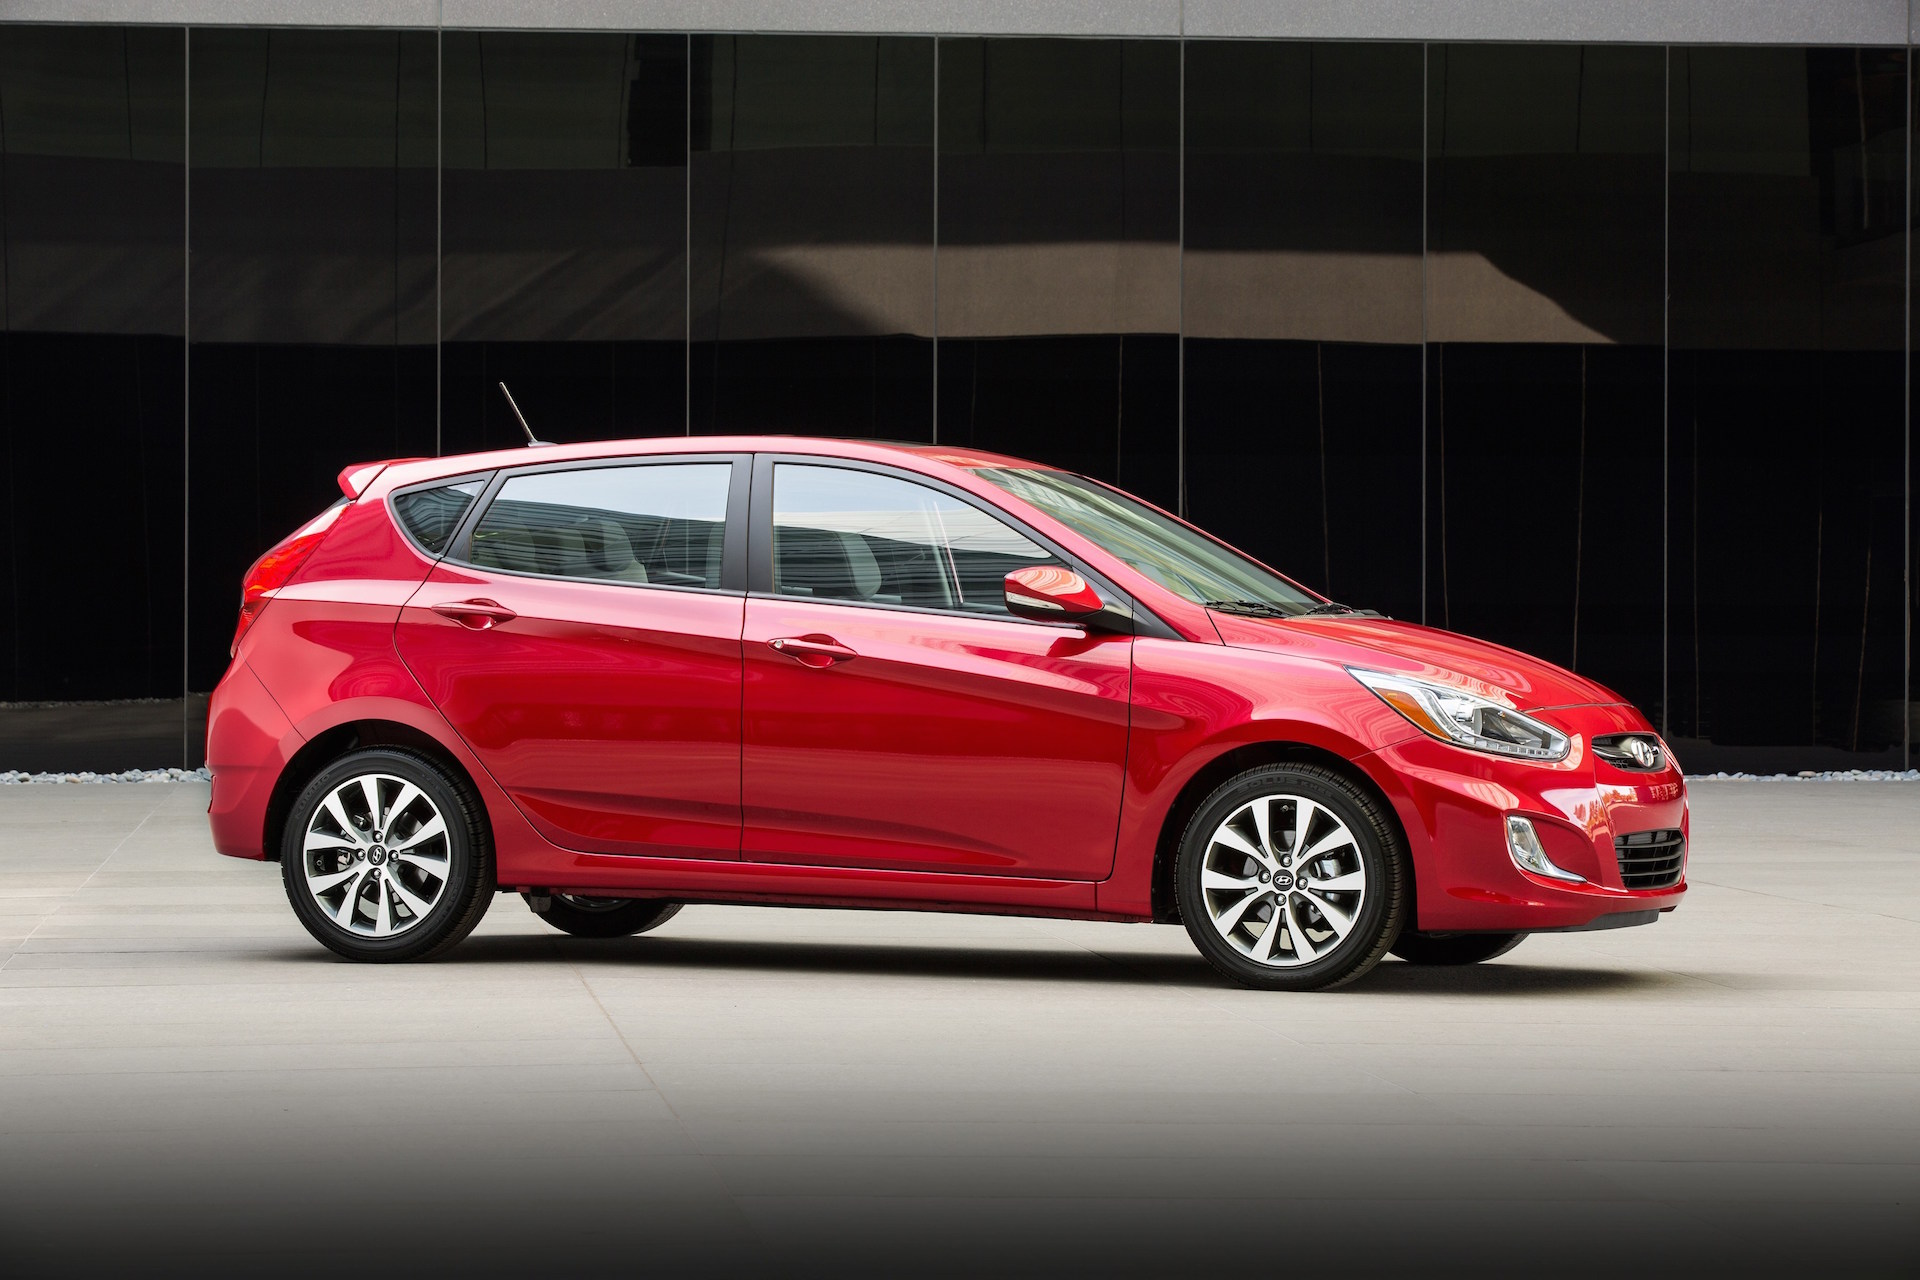

In [ ]:
# Veamos alguna de las imágenes
random_img = np.random.choice(train_generator.filenames)
print(random_img)
Image.open(path + '/' + random_img)

# Modelos

## Red preentrenada

In [ ]:
base_model = ResNet50(include_top=False, input_shape=(img_size,img_size,3), pooling='avg')
base_model.trainable = False
base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

## Cabecera de clasificacion

In [ ]:
cls_model = Sequential()

cls_model.add(Dense(128, activation='relu', input_shape=(2048,)))
cls_model.add(Dense(train_generator.num_classes, activation='softmax'))

cls_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
cls_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 262659 (1.00 MB)
Trainable params: 262659 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
final_model = Sequential()

final_model.add(base_model)
final_model.add(cls_model)

final_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 sequential (Sequential)     (None, 3)                 262659    
                                                                 
Total params: 23850371 (90.98 MB)
Trainable params: 262659 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


# Precompute

In [ ]:
path = 'imagenes1'
# Vamos a crear nuevamente el generator, pero esta vez con el parámetro "shuffle=False",
# para obtener los resultados en orden
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,classes=['hyundaiaccent', 'kiario', 'toyotahilux'])

Found 81 images belonging to 3 classes.


In [ ]:
n_batch = math.ceil(train_generator.samples / batch_size)
n_batch

2

In [ ]:
# Reseteamos el status del generador para comenzar en orden
train_generator.reset()

# Variables donde vamos a guardar los features extraidos
outputs_x = []
outputs_y = []

for i in tqdm(range(n_batch)):
    # Obtenemos la información del batch
    batch_x, batch_y = train_generator.next()

    # Guardamos el resultado del base_model
    outputs_x.append(base_model.predict_on_batch(batch_x))

    # Guardamos tambien los labels
    outputs_y.append(batch_y)

# Usamos la función "vstack" de numpy, para juntar los resultados en forma de un numpy array
outputs_x = np.vstack(outputs_x)
outputs_y = np.vstack(outputs_y)
outputs_x.shape, outputs_y.shape

100%|██████████| 2/2 [00:16<00:00,  8.20s/it]


((81, 2048), (81, 3))

In [ ]:
# Guardamos los arrays
np.savez_compressed('imagenes1prec/carros_precomputed', x=outputs_x, y=outputs_y)
#OTRO CAMBIO AQUI

In [ ]:
# Cargar arrays
data = np.load('imagenes1prec/carros_precomputed.npz')
#OTRO CAMBIO AQUI
outputs_x = data['x']
outputs_y = data['y']

outputs_x.shape, outputs_y.shape

((81, 2048), (81, 3))

# Entrenar con los features extraidos

In [ ]:
log = cls_model.fit(outputs_x, outputs_y, epochs=5, batch_size=256)

Epoch 1/5
1/1 [==============================] - 0s 494ms/step - loss: 1.9008 - accuracy: 0.3086
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 2.1592 - accuracy: 0.5679
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 1.9073 - accuracy: 0.6543
Epoch 4/5
1/1 [==============================] - 0s 14ms/step - loss: 1.2721 - accuracy: 0.6914
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 0.6879 - accuracy: 0.6914


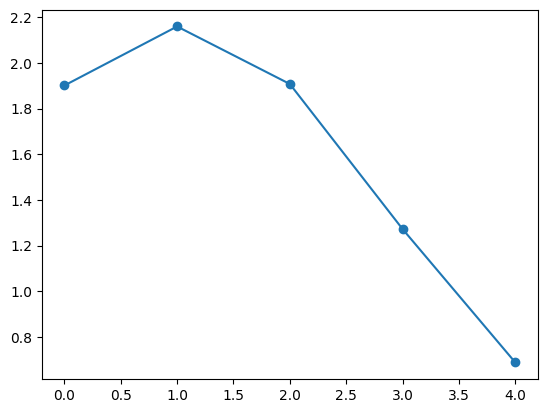

In [ ]:
plt.plot(log.history['loss'], '-o');

# Probando el modelo

In [ ]:
lbl_dict = {k:i for i,k in train_generator.class_indices.items()}

def get_class(path):
    # Cargar la imagen del path
    img = Image.open(path).convert('RGB')

    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')

    # Cambiar el tamaño de la imagen
    img_resized = img.resize((224, 224))

    # Cambiar a formato numpy y preprocesar
    x = np.asarray(img_resized, np.float32)[None]
    x = preprocess_input(x)

    # Obtener predicciones
    y = final_model.predict(x)

    # Decodear predicciones
    pred = lbl_dict[np.argmax(y)]

    plt.title(f'Model prediction = {pred}')
    plt.show()


imagenes1/toyotahilux/7.2023-Toyota-HiLux-SR5-HERO-16x9-1-1.jpg
1/1 [==============================] - 1s 915ms/step


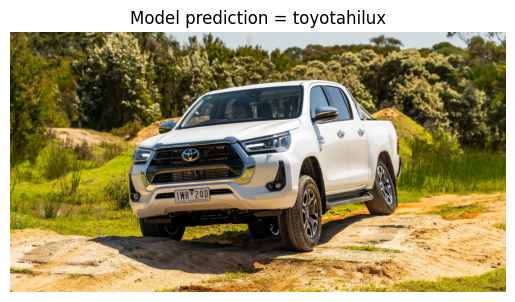

imagenes1/toyotahilux/30.2023-Toyota-HiLux-Rogue-24.jpg
1/1 [==============================] - 0s 137ms/step


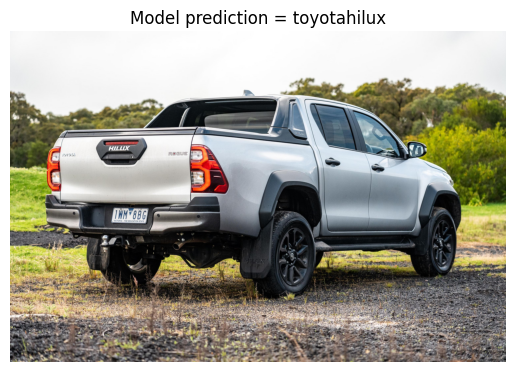

imagenes1/toyotahilux/24.2023-Toyota-Hilux-Rogue.jpg
1/1 [==============================] - 0s 150ms/step


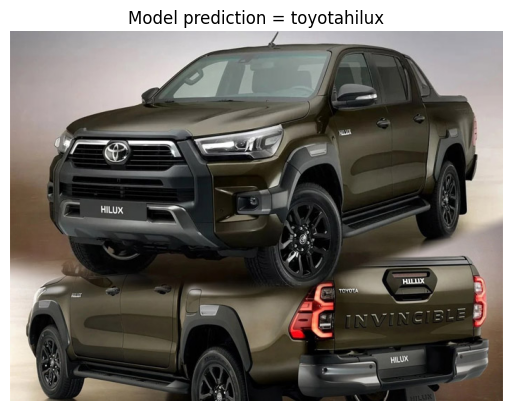

imagenes1/hyundaiaccent/24.Hyundai-Accent-GLS-sedan.jpg
1/1 [==============================] - 0s 141ms/step


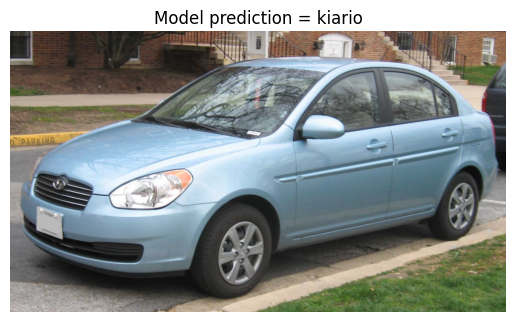

imagenes1/kiario/9.dsc_3571.jpg
1/1 [==============================] - 0s 146ms/step


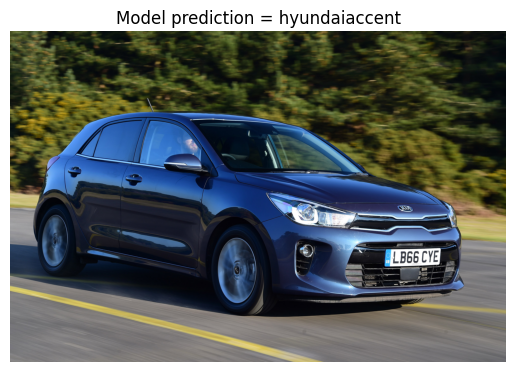

imagenes1/toyotahilux/3.2023-Toyota-Hilux-Exterior.png
1/1 [==============================] - 0s 196ms/step


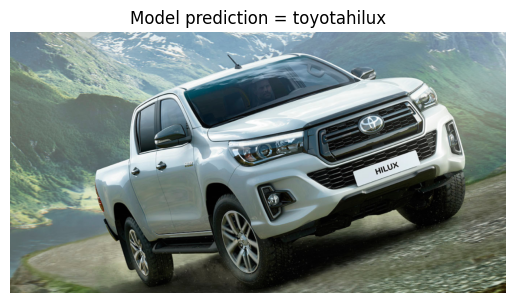

imagenes1/toyotahilux/22.Toyota-Hilux_2020_Apvidus_227154618.jpg
1/1 [==============================] - 0s 210ms/step


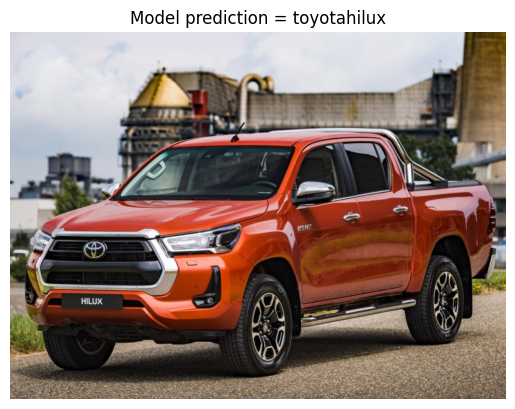

imagenes1/hyundaiaccent/10.2017-hyundai-accent_100577974_h.jpg
1/1 [==============================] - 0s 158ms/step


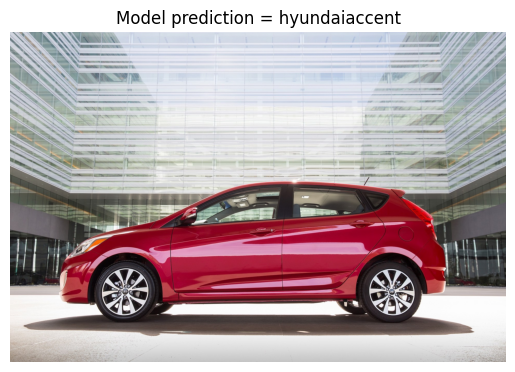

imagenes1/toyotahilux/12.HI1.jpg
1/1 [==============================] - 0s 144ms/step


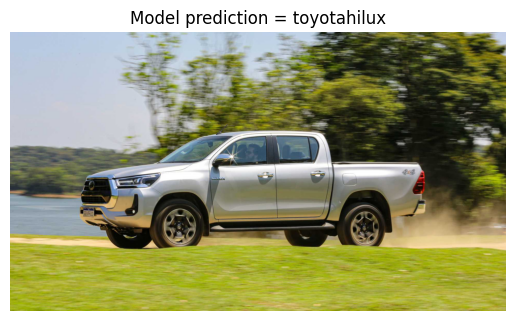

imagenes1/toyotahilux/14.2023-Toyota-hilux-Rogue-ute-silver-mark-oastler-1001x565-(1).jpg
1/1 [==============================] - 0s 140ms/step


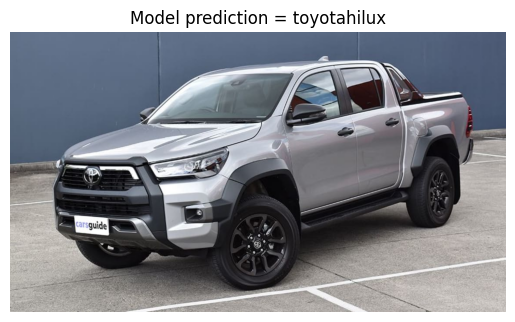

In [ ]:
# Nro de pruebas
n = 10

for _ in range(n):
    # Escoger una imagene al azar
    random_path = path + '/' + np.random.choice(train_generator.filenames)
    print(random_path)

    # Obtener la clasificación de la imagen
    get_class(random_path)